# Particle Filtering Gaussian State Space Model + ESS Resampling

In [1]:
from DataUtils import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

## Reading Sensor Data

In [2]:
data_interface = DataInterface(
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
)

In [3]:
data = data_interface.read()

In [4]:
gps = data['gps_data']
imu = data['imu_data']
enc = data['encoders_data']

In [5]:
R = 6_371_000 #earth's radius in meters
lat0 = gps[1]
lon0 = gps[2]
z0 = gps[3]
convert_lon = 1/R
baseline = 1
#8x8
C = np.zeros(shape=(8,8), dtype=np.float32)

#longitude
C[0,0] = convert_lon
#latitude
C[1,1] = 1/R
#altitude
C[2,2] = 1

#left encoder
C[3,3] = 1
C[3,4] = -baseline/2

#right encoder
C[4,3] = 1
C[4,4] = baseline/2

#yaw, pitch, roll
C[5,5] = 180/np.pi
C[6,6] = 180/np.pi
C[7,7] = 180/np.pi

## Testing Parts of Gaussian Particle Filter

In [6]:
gps_cov = gps[4:].reshape(3,3)

### convert data -> measurement vector

In [7]:
left0,right0 = enc[1:3]

In [8]:
# data -> (lon,lat,alt,left,right,yaw,pitch,roll)
# meas_vector -> (x,y,z,v,w,yaw,pitch,roll)
lat,lon,alt = gps[1:4]
lat -= lat0
lon -= lon0
alt -= z0

pitch, roll, yaw = imu[5:8]
left,right = enc[1:3]

left -= left0
right -= right0

y_t = np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
print(y_t)

[[   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [-168.91395626]
 [  -0.2013542 ]
 [   0.63600743]]


In [9]:
print( np.linalg.inv(C) @ y_t ) #predicted state vector

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-2.94810467]
 [-0.00351429]
 [ 0.01110042]]


### measurement matrix test

In [10]:
#measurement matrix test
x0 = np.array([[50,100,5,10,20,np.pi/2,np.pi/8,0]]).T
meas = C @ x0

In [11]:
meas

array([[7.84806176e-06],
       [1.56961235e-05],
       [5.00000000e+00],
       [0.00000000e+00],
       [2.00000000e+01],
       [9.00000011e+01],
       [2.25000003e+01],
       [0.00000000e+00]])

### transition function test

In [12]:
def stateUpdate(state):
    x,y,z,v,w,yaw,pitch,roll = state[:,0]
    x = x + v*np.cos(pitch)*np.cos(yaw)
    y = y + v*np.cos(pitch)*np.sin(yaw)
    z = z + v*np.sin(pitch)
    
    yaw = yaw + w
    pitch = pitch
    roll = roll
    state_ = np.array([[x,y,z,v,w,yaw,pitch,roll]]).T
    return state_

In [13]:
stateUpdate(x0)

array([[ 50.        ],
       [109.23879533],
       [  8.82683432],
       [ 10.        ],
       [ 20.        ],
       [ 21.57079633],
       [  0.39269908],
       [  0.        ]])

### Particles Initialization

In [14]:
np.linalg.inv(C) @ y_t

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-2.94810467],
       [-0.00351429],
       [ 0.01110042]])

In [15]:
Q = np.eye(8,dtype=np.float32)*1
Q_inv = np.linalg.inv(Q)

R = np.eye(8,dtype=np.float32)*1
R[0:3,0:3] = gps_cov
R_inv = np.linalg.inv(R)

sig0 = np.linalg.inv(Q_inv + C.T @ R_inv @ C)
mu0  = sig0 @ ( C.T @ R_inv @ y_t )

n_particles = 100
particle = np.random.multivariate_normal(mu0.flatten(),sig0, size=(1))

In [16]:
particle.T

array([[-0.49080761],
       [ 0.15888972],
       [ 0.4181976 ],
       [ 0.25467168],
       [ 1.83049925],
       [-2.94556707],
       [-0.01559017],
       [ 0.00317331]])

In [17]:
particles = np.random.multivariate_normal(mu0.flatten(),sig0, size=(n_particles,))
print(particles.shape)

(100, 8)


### weight initialization

In [18]:
pred = np.linalg.inv(C) @ y_t

meas_pred_dist = (y_t - C@pred)
weight = np.exp(-0.5 *  (meas_pred_dist.T @ np.linalg.inv(sig0) @ meas_pred_dist) )[0,0]

In [19]:
particles = np.random.multivariate_normal(mu0.flatten(),sig0, size=(n_particles,))
weights = np.zeros((n_particles,), dtype=np.float32)
w_sum = 0
for i in range(n_particles):
    x_t = particles[i,:].reshape(8,1)
    
    weights[i] = ((y_t - C@x_t).T @ np.linalg.inv(sig0) @ (y_t - C@x_t))[0,0]
    w_sum += weights[i]
weights /= w_sum

In [20]:
weights

array([0.00299745, 0.00746176, 0.00880936, 0.00855721, 0.00820415,
       0.00433727, 0.01670505, 0.01245251, 0.00021075, 0.01755461,
       0.03428683, 0.01319843, 0.00256094, 0.01932883, 0.01003752,
       0.02043088, 0.01322721, 0.01119738, 0.00877646, 0.02674945,
       0.00249601, 0.00208359, 0.02508472, 0.01173167, 0.00896746,
       0.00828128, 0.00318906, 0.00525393, 0.00701036, 0.01519036,
       0.01342375, 0.01836158, 0.02060501, 0.01514728, 0.00871987,
       0.00842884, 0.01270572, 0.00864877, 0.01161392, 0.00351868,
       0.00017981, 0.0017112 , 0.00492918, 0.00106058, 0.01323944,
       0.00385184, 0.01266787, 0.01001989, 0.01979101, 0.01040837,
       0.00360585, 0.00499951, 0.00212411, 0.00566469, 0.01277203,
       0.01094847, 0.00334502, 0.00281819, 0.00605965, 0.00978345,
       0.00706051, 0.00433261, 0.0373181 , 0.00590218, 0.00526876,
       0.00745874, 0.00118002, 0.01547349, 0.0069319 , 0.01435721,
       0.00960424, 0.00754938, 0.00180264, 0.01749093, 0.00946

### ESS Calculator

In [21]:
ESS = 1 / np.sum( weights**2 )
print(ESS)

63.618340375495336


### Make Initial Estimation and Visualize Particles

In [22]:
avg = np.sum( particles * weights.reshape(n_particles,1), axis=0)

In [23]:
avg

array([-8.10182336e-02,  7.28264327e-02,  2.20778455e-01, -4.35826088e-02,
       -2.67523342e-01, -2.94642943e+00, -2.24914757e-03,  9.30019473e-03])

(100, 3)


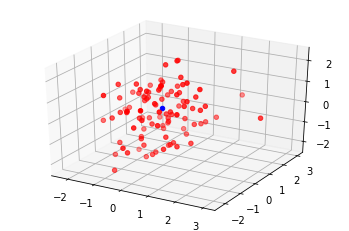

In [27]:
x0 = avg.reshape(8,1)
data = particles[:,:3]
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x0[0,:], x0[1,:], x0[2,:],c='blue')
ax.scatter(data[:,0], data[:,1], data[:,2], c='red')
plt.show()

### Predict based on previous State

In [28]:
particles.shape

(100, 8)

In [29]:
data = data_interface.read()
gps = data['gps_data']
imu = data['imu_data']
enc = data['encoders_data']

In [30]:
# data -> (lon,lat,alt,left,right,yaw,pitch,roll)
# meas_vector -> (x,y,z,v,w,yaw,pitch,roll)
lat,lon,alt = gps[1:4]
lat -= lat0
lon -= lon0
alt -= z0

pitch, roll, yaw = imu[5:8]
left,right = enc[1:3]

left -= left0
right -= right0

y_t = np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
print(y_t)

[[ 3.00000011e-07]
 [-3.99999998e-07]
 [ 6.20000000e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.68914012e+02]
 [-1.99241344e-01]
 [ 6.31612644e-01]]


In [31]:
particles1 = np.zeros(particles.shape,dtype=np.float32)
weights1 = np.zeros((n_particles,), dtype=np.float32)

w_sum = 0
for i in range(n_particles,):
    f_x1 = stateUpdate(particles[i,:].reshape(8,1))
    mu = sig0 @ (Q_inv@f_x1 + C.T @ R_inv @ y_t)
    particles1[i,:] = np.random.multivariate_normal(mu.flatten(),sig0)
    
    weights1[i] = ((y_t - C@f_x1).T @ np.linalg.inv(sig0) @ (y_t - C@f_x1))[0,0]
    w_sum += weights1[i]
weights1 /= w_sum

In [32]:
particles[i,:].reshape(8,1)

array([[ 1.38172434e+00],
       [-1.99865163e-03],
       [ 5.18574455e-01],
       [ 7.85875441e-01],
       [-3.28355207e-01],
       [-2.97437139e+00],
       [-6.98086743e-03],
       [-1.19435351e-02]])

In [33]:
stateUpdate(particles[i,:].reshape(8,1))

array([[ 0.6068299 ],
       [-0.13279895],
       [ 0.51308841],
       [ 0.78587544],
       [-0.32835521],
       [-3.30272659],
       [-0.00698087],
       [-0.01194354]])

In [37]:
avg1 = np.sum( particles1 * weights1.reshape(n_particles,1), axis=0)
print(avg1)

[-0.24330866 -0.24235979 -0.11798656  0.06076411 -0.7446521  -2.9465663
 -0.00646167  0.01240071]


In [38]:
ESS1 = 1 / np.sum( weights1**2 )
print(ESS1)

26.231089018061784


(100, 3)


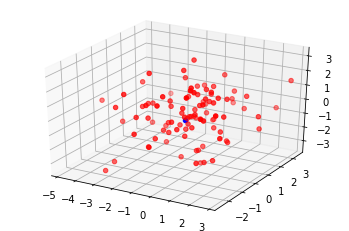

In [39]:
x0 = avg1.reshape(8,1)
data = particles1[:,:3]
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x0[0,:], x0[1,:], x0[2,:],c='blue')
ax.scatter(data[:,0], data[:,1], data[:,2], c='red')
plt.show()

### Resample

In [57]:
def resample(weights, particles, n_particles):
    #weights should be normalized
    choices = np.random.choice( np.arange(n_particles), n_particles, p=weights)
    particles_new = particles[choices,:]
    weights_new = 1/n_particles + np.zeros(weights.shape,dtype=np.float32)
    return weights_new, particles_new

In [50]:
choices = np.random.choice( np.arange(n_particles), n_particles, p=weights1 )
particles2 = particles1[choices, :]
weights2 = 1/n_particles + np.zeros(weights1.shape,dtype=np.float32)

In [54]:
ESS2 = 1 / np.sum( weights2**2 )
print(ESS2)

100.00002086163002


In [56]:
avg2 = np.sum( particles2 * weights2.reshape(n_particles,1), axis=0)
print(avg2)

[-0.2121216  -0.42971933 -0.19690984  0.12207516 -0.88960695 -2.9470592
 -0.0059156   0.01350647]


## Full Gaussian Particle Filter Implementation

In [ ]:
class GaussianParticleFilter:
    def __init__(self, systemCov, measCov, stateUpdate, measMatrix, initialMeas, n_particles=100):
        '''
            systemCov = State Update Covariance Matrix
            measCov = Measurement Covariance Matrix (Sensor Covariances)
            stateUpdate = python function that takes in previous state and predicts next state
            measMatrix = matrix that converts state vector to measurement vector
            initialState = starting off state
        '''
        
        #standard setting up A,C,Q,R
        self.stateUpdate = stateUpdate
        self.Q = systemCov
        self.R = measCov
        self.C = measMatrix
        
        self.x0 = initialState
        self.y0 = initialMeas
        
        #setup for easier computation
        Q_inv = np.linalg.inv(self.Q)
        R_inv = np.linalg.inv(self.R)
        
        self.sig = np.linalg.inv(self.C.T @ R_inv @ self.C)
        
        #initial Mu
        mu0  = sig0 @ ( self.C.T @ R_inv @ self.y0)
        
        #initialize particles
        self.particle_states = np.random.multivariate_normal(mu0,self.sig,size=(n_particles,))
        self.weights = np.zeros(self.particle_states.shape, dtype=np.float32)
        inv_cov = np.linalg.inv( self.Q + C @ self.R @ C.T )
        sum_weights = 0
        for i in range(n_particles):
            x_est = self.particle_states[i]
            weight = np.exp( -0.5 * (self.y0 - self.C @ x_est).T @ (inv_cov) @ (self.y0 - self.C @ x_est) )
            self.weights[i] = weight
            sum_weights += weight
        self.weights /= sum_weights #normalize weights
        
        self.n_particles = n_particles
        self.ESS = None
        
    def update(self, measVector):
        inv_cov = np.linalg.inv( self.Q + C @ self.R @ C.T )
        Q_inv = np.linalg.inv(self.Q)
        R_inv = np.linalg.inv(self.R)
        sum_weights = 0
        for i in range(n_particles):
            f_x1 = self.stateUpdate( self.particle_states[i] )
            
            mu = self.sig @ (Q_inv @ f_x1 + C.T @ R_inv @ measVector)
            
            particle = np.random.multivariate_normal(mu,self.sig)
            
            weight = np.exp( -0.5 * (measVector - self.C @ f_x1).T @ (inv_cov) @ (measVector - self.C @ f_x1) )
            self.weights[i] = weight
            self.particle_states[i] = particle
            sum_weights += weight
        self.weights /= sum_weights #normalize weights
        
    def calcESS(self):
        sum_normals = 0
        for i in range(n_parcles):
            sum_normals += self.weights[i]**2
        self.ESS = 1 / sum_normals   
        
        return self.ESS
    def resample(self):
        pass
    def getEstimate(self):
        avg = np.zeros(self.particle_states[0].shape,dtype=np.float32)
        for i in range(self.n_particles):
            avg += self.weights[i]*self.particle_states[i]
        return avg